In [1]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4 pydantic==2.11.9

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-classic 1.0.1 requires langchain-core<2.0.0,>=1.2.5, but you have langchain-core 0.3.59 which is incompatible.
langchain-classic 1.0.1 requires langchain-text-splitters<2.0.0,>=1.1.0, but you have langchain-text-splitters 0.3.8 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
from typing import Annotated
from langchain_core.tools import tool
import pandas as pd
import os
from dotenv import load_dotenv


@tool
def fpl_data_tool(
    player_name: Annotated[str, "The name of the FPL player to retrieve their performance data."], 
    num_gameweeks: Annotated[int, "The number of gameweeks of performance data required to respond to the user query."]
) -> str:
    """
    Use this to look-up FPL player performance data to retrieve a table from a CSV. You may need to convert weeks, months, and years, into gameweeks.
    """
    
    # Load the CSV for the player requested
    file_path = f"data/fpl_players/{player_name.replace(' ', '_').lower()}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for player {player_name} is not available. Please try another player."
    
    fpl_df = pd.read_csv(file_path, index_col='Gameweek', parse_dates=False)

    # Maximum num_gameweeks supported by the dataset
    max_num_gameweeks = fpl_df.index.max()
    
    if num_gameweeks > max_num_gameweeks:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."
    
    # Filter the DataFrame to get the last num_gameweeks of performance data
    filtered_df = fpl_df[fpl_df.index > (max_num_gameweeks - num_gameweeks)]

    return f"Successfully executed the FPL player performance data retrieval tool to retrieve the last *{num_gameweeks} gameweeks* of data for player **{player_name}**:\n\n{filtered_df.to_markdown()}"


@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."], 
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """
    
    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."
    
    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date
    
    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days
    
    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."
    
    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

In [89]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
load_dotenv()

# Add three tools to the list: wikipedia_tool, stock_data_tool, and python_repl_tool
tools = [wikipedia_tool, stock_data_tool, python_repl_tool]

llm = ChatOpenAI(model="gpt-4o-mini", base_url='https://openrouter.ai/api/v1', openai_api_key=os.getenv('OPENAI'))
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [90]:
from langgraph.prebuilt import ToolNode, tools_condition

# Create the llm and tools nodes
graph_builder.add_node("llm", llm_node)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add the edges
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition, ['tools', END])
graph_builder.add_edge("tools", "llm") 

graph = graph_builder.compile()

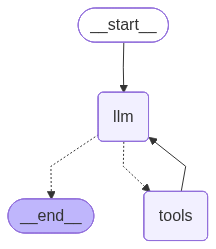

In [91]:
# Visualize your graph
graph

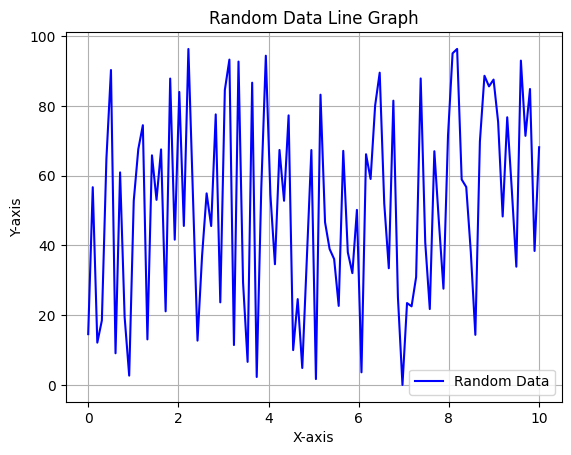

{'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mmDupGkBsMNPz3CAc2NqdHMg', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport numpy as np\\n\\n# Generate random data\\nx = np.linspace(0, 10, 100)  # 100 points from 0 to 10\\n\\ny = np.random.rand(100) * 100  # 100 random values between 0 and 100\\n\\n# Create the line graph\\nplt.plot(x, y, label=\'Random Data\', color=\'blue\')\\n\\n# Add titles and labels\\nplt.title(\'Random Data Line Graph\')\\nplt.xlabel(\'X-axis\')\\nplt.ylabel(\'Y-axis\')\\nplt.legend()\\n\\n# Show plot\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 250, 'total_tokens': 406, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_t

In [92]:
for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "create a line graph using random data."}]}
):
    print(chunk)